In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import modeling
from scipy.optimize import curve_fit

In [62]:
def lc_brokenpowerlaw(x,x_break,y_break,x_off,y_off,alpha_1,alpha_2):
    astbpl = modeling.powerlaws.BrokenPowerLaw1D(amplitude = y_break, x_break = x_break, alpha_1 = alpha_1, alpha_2 = alpha_2)
    y = -(astbpl(x-x_off))+y_off
    return y
def lc_powerlaw(x,x_0,y_0,alpha,x_off,y_off):
    astpl = modeling.powerlaws.PowerLaw1D(amplitude = y_0, x_0 = x_0, alpha = alpha)
    y = -(astpl(x-x_off))+y_off
    return y
def shortenlist(list1,list2,start,end):
    list1_arr = np.asarray(list1)
    short_list1 = []
    short_list2 = []
    for aa in list1:
        if aa >= start and aa <= end:
            short_list1.append(aa)
            short_list2.append(list2[int(np.where(list1_arr == aa)[0])])
    return short_list1,short_list2
def brokenpowerlaw(x, x0, y1, y2, k1, k2):
    return -(np.piecewise(x, [x < x0], [lambda x:k1**x + y1, lambda x:k2**x + y2]))
def piecewise_fitter(xlist, ylist, func, p0):
    x_arr = np.asarray(xlist)
    y_arr = np.asarray(ylist)
    a = 0
    split = p0[0]
    p0_short = p0[1:]
    while a == 0:
        popt, pcov = curve_fit(func, xlist, ylist, p0 = [split]+p0_short)
        s = 0
        popt_short = popt[1:]
        for i, x in enumerate(xlist):
            s += (ylist[i] - func(x,split,*popt_short))**2
        rightside = np.where(x_arr >= split)[0]
        leftside = np.where(x_arr <= split)[0]
        if rightside[0] > leftside[-1]:
            right = np.mean(np.array([xlist[rightside[0]],xlist[rightside[1]]]))
            left = np.mean(np.array([xlist[leftside[-2]],xlist[leftside[-1]]]))
        elif rightside[0] == leftside[-1]:
            right = xlist[rightside[0]+1]
            left = xlist[rightside[0]-1]
        else:
            right = 'error'
            left = 'error'
        #right side
        rpopt, rpcov = curve_fit(func, xlist, ylist, p0 = [right]+p0_short)
        rsplit = rpopt[0]
        rs = 0
        for i, x in enumerate(xlist):
            rs += (ylist[i] - func(x,*rpopt))**2
        #left side
        lpopt, lpcov = curve_fit(func, xlist, ylist, p0 = [left]+p0_short)
        lsplit = lpopt[0]
        ls = 0
        for i, x in enumerate(xlist):
            ls += (ylist[i] - func(x,*lpopt))**2
        #
        optmax = int(np.argmin(np.asarray([s,rs,ls])))
        optpos = [split,rsplit,lsplit][optmax]
        if optpos < xlist[1] or optpos > xlist[-2]:
            a = 1
            print('Iteration went out of bounds. Returning most recent iteration.')
        elif optmax == 0:
            a = 1
        elif optmax != 0:
            split = optpos
    return split

In [63]:
a = modeling.powerlaws.BrokenPowerLaw1D(amplitude=2, x_break=80, alpha_1=0.4, alpha_2=3)
x = np.linspace(5, 200, 75)
dx = np.linspace(5, 200, 500)
y_original = -(a(dx-(-5)))+12
y = -(a(x-(-5)))+12
y_noisy = []
for mag in y:
    y_noisy.append(mag + np.random.normal(0,0.03))

In [64]:
astbpl = modeling.powerlaws.BrokenPowerLaw1D(bounds={'x_break':(50,100)})
fitter = modeling.fitting.SLSQPLSQFitter()
best_fit = fitter(astbpl, x, y_noisy)
print(best_fit)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.411629996090066
            Iterations: 28
            Function evaluations: 167
            Gradient evaluations: 28
Model: BrokenPowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude          x_break             alpha_1             alpha_2       
    ----------------- ------------------ ------------------- --------------------
    9.826072520106433 54.201759191077535 -0.1143135365956442 -0.16650983160487434


c:\Users\oh0si\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\modeling\statistic.py:61: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(weights * np.subtract(model_vals, measured_vals)))
c:\Users\oh0si\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\modeling\powerlaws.py:126: RuntimeWarning: overflow encountered in power
  return amplitude * xx ** (-alpha)


In [65]:
def BrokenPowerLaw1Dfit(x_data, y_data, iterations = 100, x_bounds = None):
    x_data_arrayreplacer = x_data
    y_data_arrayreplacer = y_data
    x_data = np.asarray(x_data_arrayreplacer)
    y_data = np.asarray(y_data_arrayreplacer)
    fitter = modeling.fitting.SLSQPLSQFitter()
    x_off = 0
    if x_bounds == None:
        bounds_x = None
    stopper = 0
    cap_stopper = 0
    while stopper != 1 and cap_stopper < iterations:
        cap_stopper += 1
        if x_bounds != None:
            bounds_x = {'x_break':(x_bounds[0], x_bounds[1])}
            astbpl_newbounds = modeling.powerlaws.BrokenPowerLaw1D(bounds = bounds_x)
        else:
            astbpl_newbounds = modeling.powerlaws.BrokenPowerLaw1D()
        current_fit = fitter(astbpl_newbounds, x_data, y_data)
        current_fit_params = current_fit.parameters
        def offsetfunc(x,x_offset,y_offset):
            return current_fit(x-x_offset)+y_offset
        offsetpopt, offsetpcov = curve_fit(offsetfunc, x_data, y_data)
        new_x_data = x_data - offsetpopt[0]
        new_y_data = y_data - offsetpopt[1]
        if offsetpopt[0] == 0 and offsetpopt[1] == 0:
            stopper=1
            print('optimized')
        else:
            x_data = new_x_data
            y_data = new_y_data
    return current_fit, offsetpopt

In [66]:
curfit, offsetpop = BrokenPowerLaw1Dfit(x, y_noisy, iterations = 100, x_bounds = [30,100])

c:\Users\oh0si\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\modeling\statistic.py:61: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(weights * np.subtract(model_vals, measured_vals)))
c:\Users\oh0si\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\modeling\powerlaws.py:126: RuntimeWarning: overflow encountered in power
  return amplitude * xx ** (-alpha)
c:\Users\oh0si\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\modeling\powerlaws.py:126: RuntimeWarning: overflow encountered in multiply
  return amplitude * xx ** (-alpha)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.41162993957643
            Iterations: 35
            Function evaluations: 206
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3918570227705294
            Iterations: 36
            Function evaluations: 206
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.375331584657976
            Iterations: 33
            Function evaluations: 187
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3619705278346648
            Iterations: 35
            Function evaluations: 211
            Gradient evaluations: 35
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3515487661241385
            Iterations: 35
            Function ev

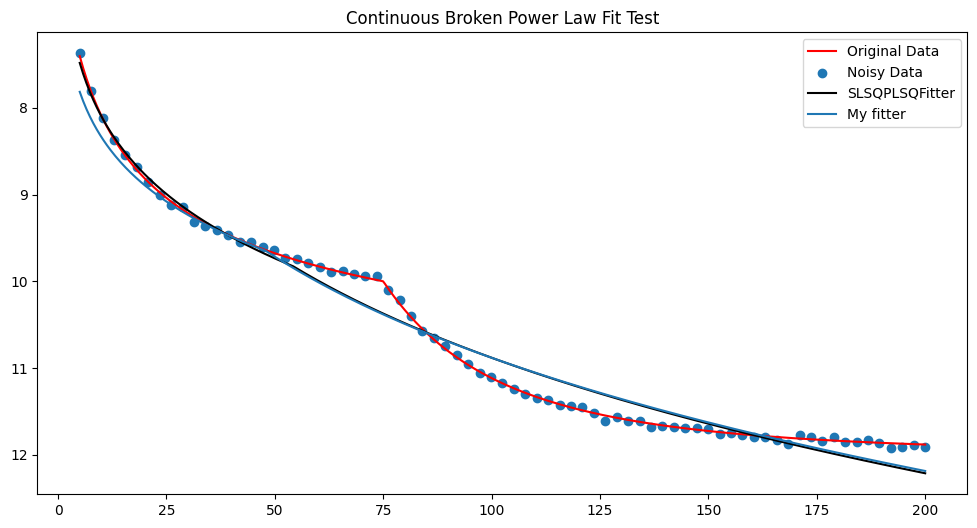

In [67]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(12, 6)
ax1.plot(dx, y_original, color='r', label="Original Data")
ax1.scatter(x, y_noisy, label="Noisy Data")
ax1.plot(dx, best_fit(dx), color='k', label="SLSQPLSQFitter")
#ax1.plot(dx, brokenpowerlaw(dx,*popt))
#ax1.plot(segment_1_x,lc_powerlaw(np.asarray(segment_1_x),*popt1))
#ax1.plot(segment_2_x,lc_powerlaw(np.asarray(segment_2_x),*popt2))
ax1.plot(dx, curfit(dx-offsetpop[0])+offsetpop[1], label="My fitter")
ax1.set_title("Continuous Broken Power Law Fit Test")
ax1.legend()
fig.gca().invert_yaxis()
fig.savefig("brokenpowerlaw_fittest.pdf",transparent=False)

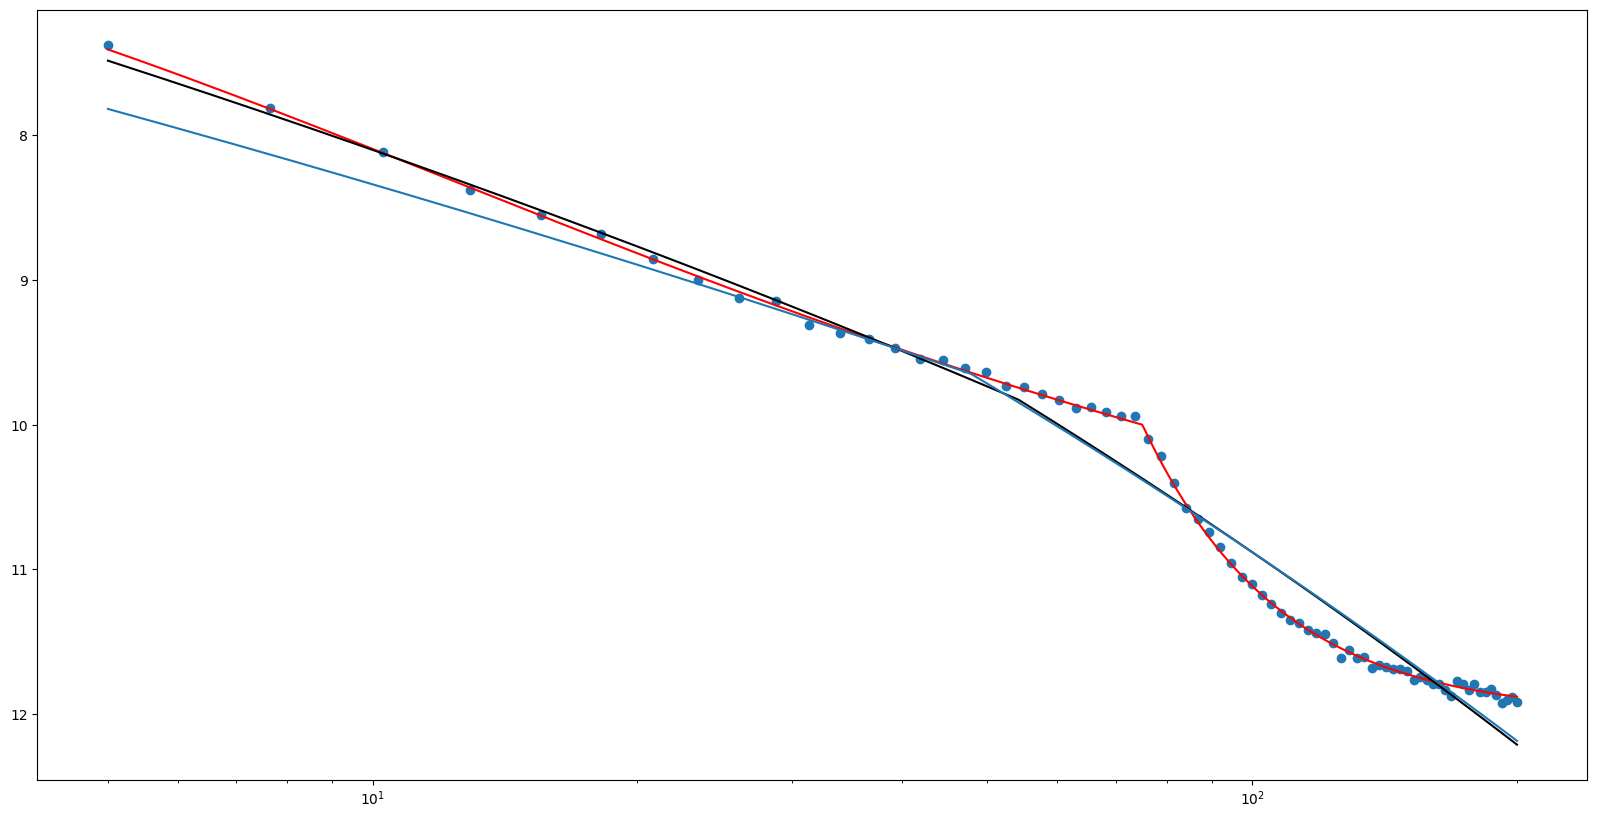

In [68]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(20, 10)
ax1.plot(dx, y_original, color='r')
ax1.scatter(x, y_noisy)
ax1.plot(dx, best_fit(dx), color='k')
#ax1.plot(dx, brokenpowerlaw(dx,*popt))
#ax1.plot(segment_1_x,lc_powerlaw(np.asarray(segment_1_x),*popt1))
#ax1.plot(segment_2_x,lc_powerlaw(np.asarray(segment_2_x),*popt2))
ax1.plot(dx, curfit(dx-offsetpop[0])+offsetpop[1])
ax1.set_xscale('log')
plt.gca().invert_yaxis()
plt.show()

In [69]:
best_fit

<BrokenPowerLaw1D(amplitude=9.82607252, x_break=54.20175919, alpha_1=-0.11431354, alpha_2=-0.16650983)>